# MNIST train

This is a part of some experiments for Knowledge Distillation.

- Train an MNIST model
- Train a smaller model (trainee) using Knowledge distillation
    - Find optimal parameter configs
- Compare with other training strategies
    - Train the smaller model from scratch
    - Train the smaller model from the trainee model's weights - does it diverge?
- Relevant metrics
    - Precision, recall, accuracy
    - Time the models

Other experiments to try:
- Other datasets?
- Mixture of experts -> one model somehow? (there'll be multiple soft targets OR mean them..)
- KD wrt different architectures:
    - ResNet -> ResNet?
    - ResNet -> simpler architecture
    - Simpler architecture to ResNet

### Other unrelated ideas

- Training strategies
    - Training techniques and tricks
        - Hard negative mining and how it helps
    - Curriculum learning
    - Annealing learning rates
    - Cyclic learning rates
    - Batch normalization

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import torch
from torch import autograd, nn, optim
import torch.nn.functional as F

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data

In [3]:
df_train_val = pd.read_csv('data/train.csv')

In [4]:
df_test = pd.read_csv('data/test.csv')

In [5]:
df_train_val.shape, df_test.shape

((42000, 785), (28000, 784))

(array([4132., 4684., 4177., 4351., 4072., 3795., 4137., 4401., 4063.,
        4188.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

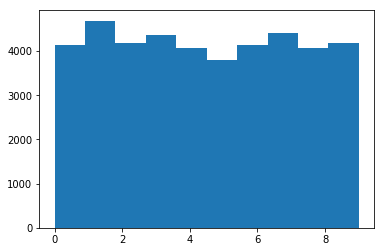

In [6]:
plt.hist(df_train_val.label)

### Split train into train-val

In [7]:
np.random.seed(1123)
df_train_val = df_train_val.sample(frac=1)

In [8]:
df_train_val.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
21290,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19992,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8221,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33538,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15284,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
val_frac = 0.1
n_train = math.ceil((1-val_frac) * df_train_val.shape[0])

df_train = df_train_val.iloc[:n_train]
df_val = df_train_val.iloc[n_train:]

assert df_train.shape[0] + df_val.shape[0] == df_train_val.shape[0]

In [10]:
df_train.shape

(37800, 785)

In [11]:
n_train = math.ceil((1-val_frac) * df_train_val.shape[0])

df_train = df_train_val.iloc[:n_train]
df_val = df_train_val.iloc[n_train:]

assert df_train.shape[0] + df_val.shape[0] == df_train_val.shape[0]

In [12]:
df_val.shape

(4200, 785)

### Create dataloaders

In [13]:
from typing import Tuple

In [14]:
from torch.utils.data import dataloader

In [15]:
def get_dataset(df) -> Tuple[np.array, np.array]:
    if 'label' not in df:
        raise ValueError('This dataframe does not have labels!')
    
    # Extract numpy arrays
    labels = df['label'].values
    images = df.drop('label', axis=1).values
    assert len(labels) == len(images)
    
    # Reshape the images to make 28*28
    images = images.reshape(-1, 1, 28, 28)
    
    # Pad to 32*32
    images = np.pad(images, ((0, 0), (0, 0), (2, 2), (2, 2)), mode='constant', constant_values=0)

    # Convert to pytorch Tensors
    images = torch.FloatTensor(images.astype(np.float32))
    labels = torch.FloatTensor(labels.astype(np.int))
    
    # Create a dataset object
    dataset = torch.utils.data.TensorDataset(images, labels)
    assert len(dataset) == len(df)
    return dataset

In [16]:
%%time
dataset_train = get_dataset(df_train)
dataset_val = get_dataset(df_val)

CPU times: user 539 ms, sys: 552 ms, total: 1.09 s
Wall time: 1.11 s


In [17]:
print(len(dataset_train))
print(len(dataset_val))

37800
4200


In [18]:
batch_size = 8

In [19]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Check sizes
for ix, _ in enumerate(dataloader_val):
    pass
assert (ix+1) * batch_size == len(dataset_val)

for ix, _ in enumerate(dataloader_train):
    pass
assert (ix+1) * batch_size == len(dataset_train)

### Visualize a few images

In [20]:
def visualize_batch(batch):
    images, labels = batch
    
    plt.figure(figsize=(20, 10))

    for ix in range(batch_size):
        plt.subplot(1, batch_size, ix+1)
        plt.imshow(images[ix].squeeze(), cmap='gray')
        plt.title(labels[ix].data.numpy())

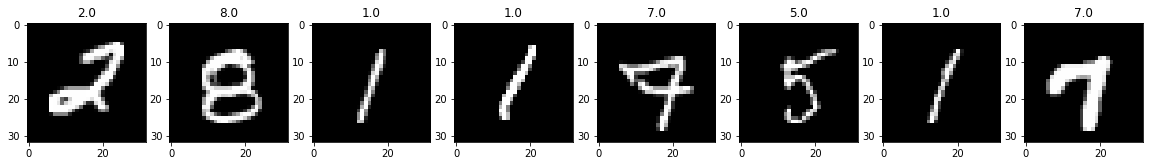

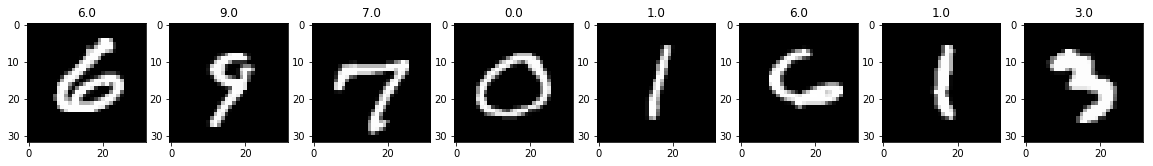

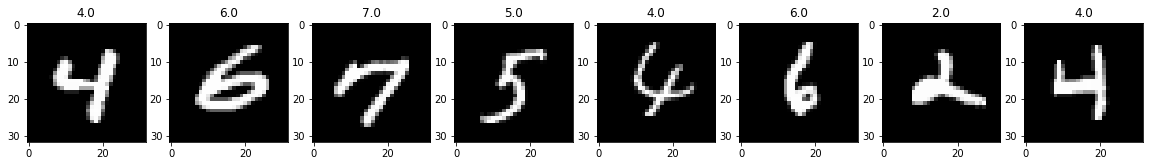

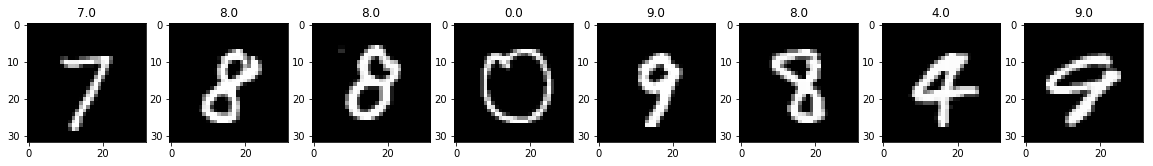

In [21]:
for ix, next_batch in enumerate(dataloader_train):
    if ix >= 4:
        break
    visualize_batch(next_batch)

### Get the relative label weights

In [22]:
loss_weights = np.bincount(df_train_val['label'])

In [23]:
loss_weights = 1. / loss_weights
loss_weights = loss_weights / loss_weights.sum()

Text(0,0.5,'Loss weight')

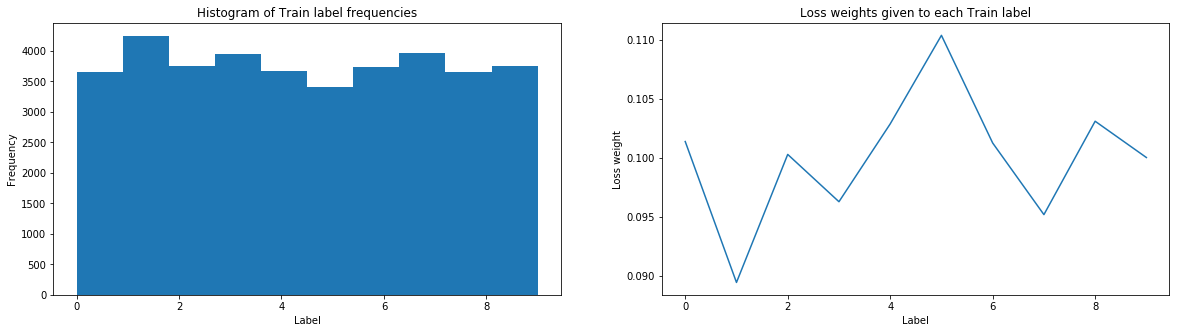

In [24]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(df_train['label'])
plt.title('Histogram of Train label frequencies')
plt.xlabel('Label')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(loss_weights)
plt.title('Loss weights given to each Train label')
plt.xlabel('Label')
plt.ylabel('Loss weight')

In [25]:
del df_train, df_val, df_train_val

## Model

### Create a simple model

In [26]:
class Net(nn.Module):
    @staticmethod
    def _make_encoder(n_in, n_out):
        return nn.Sequential(
            nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
#             nn.BatchNorm2d(num_features=n_out),
        )

    def __init__(self,) -> None:
        super().__init__()
        self.low_feat = self._make_encoder(1, 8)
        
        self.encoders = nn.Sequential(
            self._make_encoder(8, 16),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            self._make_encoder(16, 32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            self._make_encoder(32, 64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            self._make_encoder(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        
        self.linears = nn.Sequential(
            nn.Linear(512, 512),
            nn.Linear(512, 512),
        )
        
        self.classifier = nn.Linear(512, 10)
    
    def forward(self, x):
        feats = self.low_feat(x)
        encoded = self.encoders(feats).view(-1, 512)
        preds = self.linears(encoded)
        preds = self.classifier(preds)
        return F.log_softmax(preds, dim=1)

In [27]:
# Test run!
model = Net()

img, label = dataset_train[0]
img = img.view(1, 1, 32, 32)
assert model(img).shape[1] == 10 and model(img).shape[0] == 1

In [ ]:
model = Net().cuda()

In [ ]:
%%time

count = 0
params = []
for param in model.parameters():
    if param.requires_grad:
        count += np.prod(param.shape)
        params.append(param)

print('{:,} trainable paramaters!'.format(count))

### Loss, optimizer

In [ ]:
import os
import pathlib
import tensorboardX

In [ ]:
loss_weights = torch.FloatTensor(loss_weights)

loss = nn.NLLLoss(weight=loss_weights).cuda()
optimizer = optim.SGD(params, lr=1e-10)

In [ ]:
# Weights and logging directories
model_str = 'MNIST-big-1.01'

path_to_weights = pathlib.Path('./weights') / model_str
path_to_log_s = '../tensorboard/{}'.format(model_str)

# To prevent over-writing!
os.makedirs(str(path_to_weights), exist_ok=False)
writer = tensorboardX.SummaryWriter(path_to_log_s)

In [ ]:
def forward_once(model, batch, loss):
    images, labels = batch
    images = images.cuda()
    labels = labels.cuda()
    
    preds = model(images)
    error = loss(preds, labels)
    return preds, error

In [ ]:
def validate_model(model, dataloader, loss, n_iters=10, writer=None,
                   plot=True):
    model.train(False)

    total_acc = 0
    total_error = 0
    for iteration, next_batch in enumerate(dataloader):
        if iteration > n_iters:
            break

        preds, error = forward_once(model, next_batch, loss)
        acc = torch.mean(preds.data.cpu() == next_batch[1])
        
        total_error += error.data.cpu().numpy()
        total_acc += acc.data.cpu().numpy()
    
    mean_acc = total_acc / n_iters
    mean_error = total_error / n_iters

    if writer is not None:
        writer.add_scalar('val.loss', mean_error)
        writer.add_scalar('val.acc', mean_acc)

    if plot:
        visualize_batch(next_batch)
        print('Loss: {}, Accuracy: {}'.format(mean_error, mean_acc))
        print('Preds:', preds.data.cpu().numpy())

    model.train(True)
    
    return mean_error, mean_acc

In [ ]:
validate_model(model, dataloader_val, loss)

In [ ]:
%%time
save_every = 10000
val_every = 1000
log_every = 10
n_epochs = 8

model.train(True)
epochs = np.arange(n_epochs)
for epoch in epochs:
    for iteration, next_batch in enumerate(dataloader_train):
        optimizer.zero_grad()
        preds, error = forward_once(model, next_batch, loss)
        error.backward()
        acc_train = torch.mean(preds.data.cpu() == next_batch[1])
        
        if iteration % log_every == 0:
            writer.add_scalar('train.loss', error.data.cpu().numpy())
            writer.add_scalar('train.acc', acc_train)

        if iteration > 0 and iteration % save_every == 0:
            torch.save(model.state_dict(), path_to_weights / '{}-{}.pt'.format(epoch, iteration))
        
        if iteration % val_every == 0:
            validate_model(model, dataloader_val, loss)